In [ ]:
#install transformer
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip3 install --upgrade .
%cd ../

Cloning into 'transformers'...
remote: Enumerating objects: 57369, done.
remote: Total 57369 (delta 0), reused 0 (delta 0), pack-reused 57369
Receiving objects: 100% (57369/57369), 42.71 MiB | 25.44 MiB/s, done.
Resolving deltas: 100% (40252/40252), done.
/content/transformers
Processing /content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.9MB 10.3MB/s 
     |████████████████████████████████| 890kB 31.0MB/s 
  Created wheel for transformers: filename=transformers-4.2.0.dev0-cp36-none-any.whl size=1522338 sha256=8aa329370b499eb85204dd6165922133ce52ec5d0c4c2b379dfcc4af23f91a2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7fuhx0g/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=018f5ce597cfd622483210263a1

In [89]:
!pip install underthesea

     |████████████████████████████████| 7.5MB 4.5MB/s 
     |████████████████████████████████| 245kB 40.6MB/s 
     |████████████████████████████████| 6.7MB 23.6MB/s 
     |████████████████████████████████| 1.3MB 46.4MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 747kB 43.0MB/s 
     |████████████████████████████████| 753.2MB 23kB/s 
     |████████████████████████████████| 2.9MB 51.5MB/s 
     |████████████████████████████████| 890kB 41.8MB/s 
     |████████████████████████████████| 1.1MB 40.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=aab58f438d0a44f5b7b9ad0999196b39aafbe1b02ef4964fdd9b03c266fbaa01
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=5156b4fed17214c78fad4bc37b8cd96074aed6e22a884f1622dda5b33e076065
  Stored in directory:

In [91]:
import numpy as np
import pandas as pd

import pickle
import re
from underthesea import word_tokenize

In [ ]:
from transformers import TFAutoModel, AutoTokenizer
phobert = TFAutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
tokenizer.pad_token_id

1

In [ ]:
tokenizer.cls_token_id

0

In [ ]:
line1 = "Tôi là sinh_viên trường đại_học Công_nghệ ."*100
line2 = "xin chao cac ban"
tokenizer.encode(line1, padding="max_length" , max_length=10 ,truncation=True)

[0, 218, 8, 649, 212, 956, 2413, 2586, 218, 2]

In [ ]:
inputs = [tokenizer.encode(line1), tokenizer.encode(line2)]

In [ ]:
features['last_hidden_state'][:,0,:].numpy().shape

(1, 768)

In [ ]:
features['hidden_states'][5].shape

torch.Size([1, 9, 768])

# Load data

In [83]:
df = pd.read_csv("data/items_cmt_eachrate2cmt.csv", encoding='utf-8', delimiter="\t").dropna() #drop row with empty content

In [84]:
df

,id,rating,content
0,2,5.0,Giao hàng hơi lâ. Chưa bóc gói hàng nên k biết...
1,2,5.0,e đã nhận hàng nha shop . máy rất deph . ...
2,2,4.0,Mới mua lần đầu. Cầm chắc tay. Chất lượ...
4,2,3.0,Bị hở một bên không đóng kín duoc . Dùng xài ok.
7,2,1.0,"Đặt 2 cái bị hỏng cả 2. 1 cái hỏng bàn phím, 1..."
...,...,...,...
23290,15390,5.0,Ko dùng được..
23291,15390,5.0,Hàng ngon nha
23294,15390,3.0,Nó bị xụt xịt không chắc chắn.
23295,15521,5.0,"Đóng gói kĩ,nhưng chưa dùng thử nên chưa bik s..."


In [92]:
def preprocess(text):
    # remove stopword
 
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    text = re.sub(r"[\.,\?]+$-", "", text)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    text = text.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
 
    text = text.strip() #

    #segment lại các từ ghép để làm input cho BERT
    text = word_tokenize(text, format="text")
    return text


    

In [93]:
X = df['content'].to_numpy()
X = np.vectorize(preprocess)(X)


In [94]:
print(df['content'][0])
print(X[0])

Giao hàng hơi lâ. Chưa bóc gói hàng nên k biết hàng hoá ra sao nữa 
Giao hàng hơi lâ Chưa bóc gói hàng nên k biết hàng_hoá ra sao nữa


In [134]:
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# TF-IDF

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size =0.2, random_state=1)

In [137]:
extractor = CountVectorizer(min_df=5, max_df=0.8, max_features=500)
extractor.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.8, max_features=500, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [138]:
X_train =  extractor.transform(X_train)
X_test = extractor.transform(X_test)

In [140]:
model = LinearSVC(C = 1,max_iter=3000)
model.fit(X_train, np.where((y_train-1)>=3,0,1))

sc = model.score(X_test, np.where((y_test-1)>=3,0,1))
print(sc)

0.7777514231499051


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [141]:
model = LinearSVC(C = 1)
model.fit(X_train, (y_train-1))

sc = model.score(X_test, (y_test-1))
print(sc)

0.4715370018975332


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [108]:
X_train.shape 

(16861, 2781)

In [111]:
model.score(X_train, y_train-1)

0.14536504359172053

# BERT

In [ ]:
X_tokenized = [tokenizer.encode(sent) for sent in X] #Convert each word in the sentence into token_id which is input of BERT

max_length = 0
for sent in X_tokenized:
    if max_length < len(sent):
        max_length = len(sent)
  

if max_length > 256: #BERT model maximum input sequence's length
    max_length = 256 

#truncate the sentence to max_length
truncated_X_tokenized = [sent[:max_length-1] + [tokenizer.eos_token_id] if (len(sent) > max_length) else sent for sent in X_tokenized]

#padding sentence that does not have full length
padded_X_tokenized = np.array([sent + [tokenizer.pad_token_id]*(max_length-len(sent)) for sent in truncated_X_tokenized]) 
attention_mask = np.where(padded_X_tokenized == tokenizer.pad_token_id , 0,1)

print(padded_X_tokenized.shape)
print(attention_mask.shape)


Token indices sequence length is longer than the specified maximum sequence length for this model (292 > 256). Running this sequence through the model will result in indexing errors


(21077, 256)
(21077, 256)


In [142]:
with open("bert_extracted_review_data.pkl","rb") as infile:
    X,y = pickle.load(infile)

In [144]:

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size =0.2, random_state=1)

cl = LinearSVC(C=1, max_iter=3000)
cl.fit(X_train, (y_train-1))


sc = cl.score(X_test, (y_test-1))
print(sc)

0.47035104364326374


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


In [143]:

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size =0.2, random_state=1)

cl = LinearSVC(C=1, max_iter=3000)
cl.fit(X_train, np.where((y_train-1)>=4,0,1),)


sc = cl.score(X_test, np.where((y_test-1)>=4,0,1))
print(sc)

KeyboardInterrupt: ignored

In [63]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(768)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation ='softmax')
])

model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])

In [60]:
np.where((y_train-1)>=3,0,1)

array([0, 1, 0, ..., 1, 0, 0])

In [64]:
model.fit(X_train,y_train-1, epochs=80)

Epoch 1/80
527/527 [==============================] - 2s 3ms/step - loss: 1.4080 - acc: 0.3855
Epoch 2/80
527/527 [==============================] - 2s 3ms/step - loss: 1.2222 - acc: 0.4828
Epoch 3/80
527/527 [==============================] - 2s 3ms/step - loss: 1.1946 - acc: 0.4907
Epoch 4/80
527/527 [==============================] - 2s 3ms/step - loss: 1.1585 - acc: 0.5099
Epoch 5/80
527/527 [==============================] - 2s 3ms/step - loss: 1.1320 - acc: 0.5146
Epoch 6/80
527/527 [==============================] - 2s 3ms/step - loss: 1.0761 - acc: 0.5467
Epoch 7/80
527/527 [==============================] - 2s 3ms/step - loss: 1.0363 - acc: 0.5672
Epoch 8/80
527/527 [==============================] - 2s 3ms/step - loss: 0.9979 - acc: 0.5759
Epoch 9/80
527/527 [==============================] - 2s 3ms/step - loss: 0.9394 - acc: 0.6155
Epoch 10/80
527/527 [==============================] - 2s 3ms/step - loss: 0.8832 - acc: 0.6311
Epoch 11/80
527/527 [============================

In [65]:
model.evaluate(X_test, y_test-1)

132/132 [==============================] - 0s 1ms/step - loss: 7.0448 - acc: 0.4348


[7.044767379760742, 0.4347722828388214]

In [72]:
class Metrics():


    @staticmethod
    def computeMSE(y_true, y_pred):
        return np.mean((y_true-y_pred)**2)

    @staticmethod
    def computeMAE(y_true, y_pred):
        return np.mean(np.abs(y_true-y_pred))

    @staticmethod
    def computeSIA(y_true, y_pred, eps=2): #soft interval accuracy
        error = np.abs(y_true - y_pred)
        # print(y_true)
        # print(y_pred)
        # print(error)
        
        # print((error - eps) < 0 )
        res = np.mean(((error - eps) < 0 ) & (y_pred >= 0))
        return res



In [76]:
Metrics.computeSIA(total_y, total_y_pred, eps=2)

0.7725332068311196

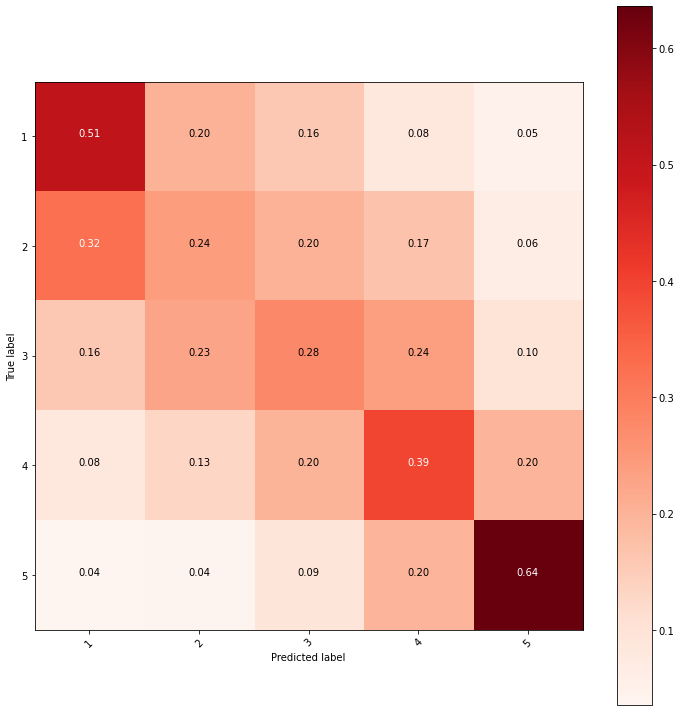

In [71]:
total_y_pred = tf.argmax(model.predict(X_test), axis=1)
total_y = y_test-1

confusion_matrix = tf.math.confusion_matrix(total_y, total_y_pred).numpy()



import matplotlib.pyplot as plt

import itertools
label_dict_test = {i+1:i for i in range(5)}



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = label_dict_test.keys()

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True,
                      title= None, cmap= plt.cm.Reds)

plt.show()